#  Problem statement

```To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.```

# Solution

## Importing Skin Cancer Data

**Installing Augmentor**

    This will be used to create samples to rectify the class imbalance issue.

In [1]:
!pip install Augmentor

### Importing all the important libraries

In [2]:
import pathlib
import os
import PIL
import random
import Augmentor

import tensorflow             as tf
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import numpy                  as np
import pandas                 as pd
import seaborn                as sns

from glob                     import glob1
from tensorflow               import keras
from tensorflow.keras         import layers
from tensorflow.keras.models  import Sequential

### Connecting to Google Drive


In [3]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


*This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.*

### Unzipping the zip datasets

In [4]:
!unzip gdrive/MyDrive/DL/CNN_assignment.zip

Archive:  gdrive/MyDrive/DL/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin

### Defining the path for train and test images after unzip

In [5]:
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

### Size of train and test datasets

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size  = 32
img_height  = 180
img_width   = 180

#### Training DataSet

Used 80% of the images for training, and 20% for validation.

In [8]:
## Note: used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Resized images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size,              # Batch Size  
    image_size=(img_height,img_width),  # Image Size 
    shuffle=True, 
    seed=123,                           # Seed = 123
    validation_split=0.2,               # Validation 20%
    subset='training',                  # training subset
    interpolation='bilinear', 
    follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### Validation DataSet

In [9]:
## Note: used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Resized images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size,              # Batch Size  
    image_size=(img_height,img_width),  # Image Size 
    shuffle=True, 
    seed=123,                           # Seed = 123
    validation_split=0.2,               # Validation 20%
    subset='validation',                # validation subset
    interpolation='bilinear', 
    follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Classes of Skin Cancers in dataset

In [10]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
list(enumerate(class_names))

[(0, 'actinic keratosis'),
 (1, 'basal cell carcinoma'),
 (2, 'dermatofibroma'),
 (3, 'melanoma'),
 (4, 'nevus'),
 (5, 'pigmented benign keratosis'),
 (6, 'seborrheic keratosis'),
 (7, 'squamous cell carcinoma'),
 (8, 'vascular lesion')]

**Number of classes**


In [11]:
num_classes = len(class_names)
num_classes

9

## Visualize the data

**Subplot to visualize one instance of all the nine classes present in the dataset**

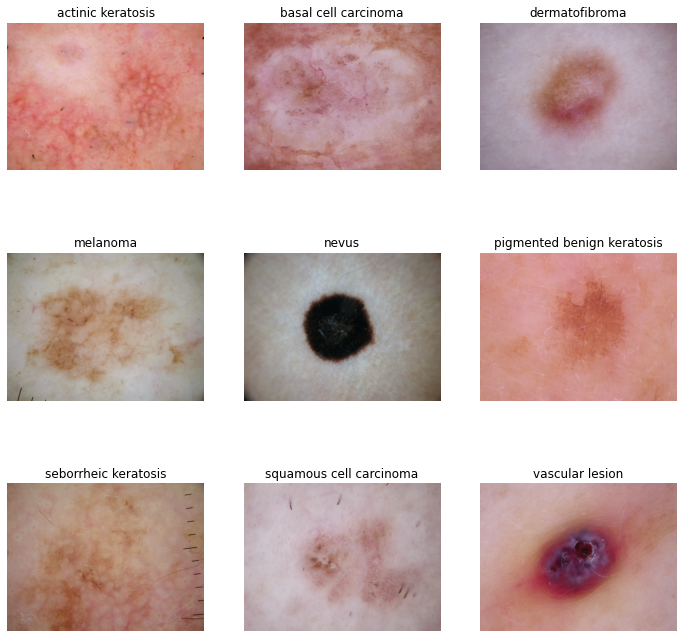

In [12]:
plt.figure(figsize=(12, 12))
image_dict=dict()

for single_path in data_dir_train.glob('*'):
    random_image = random.choice(list(single_path.glob("*.jpg")))
    image_dict[os.path.basename(single_path)] = mpimg.imread(random_image)

for i,label in enumerate(sorted(image_dict)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_dict[label])
    plt.title(label)
    plt.axis("off")

plt.show()

**Subplot to visualize first 9 images from the training dataset**

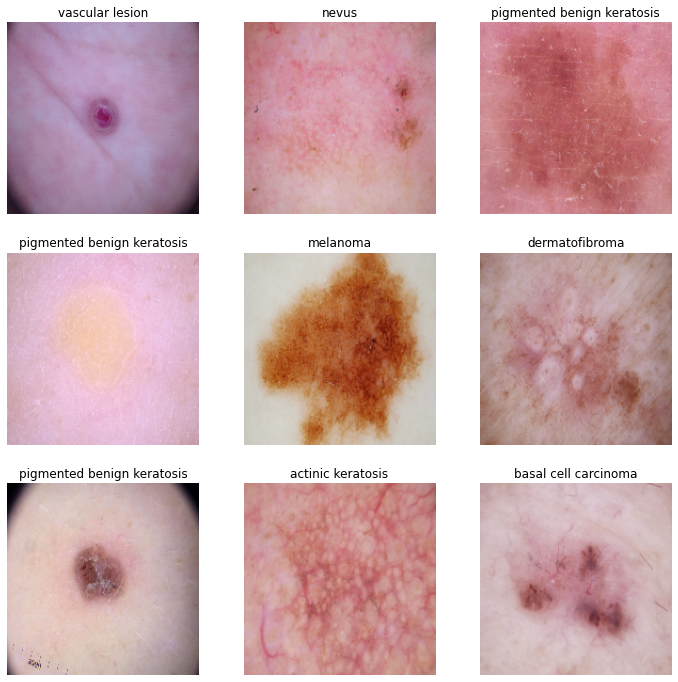

In [13]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Shape of the images and labels in the batch**

In [14]:
image_batch, labels_batch = next(iter(train_ds))
print(image_batch.shape)
print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Cache and Prefetch

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Base Model

### Create the model


- CNN model, which can accurately detect 9 classes present in the dataset. 
- Used ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
- The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

*This is an initial base model and hence drop out or batch normalization is not used.*

In [16]:
### input Shape
input_shape = (img_height,img_width,3)

# Model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model


In [17]:
### Used adam optimizer and loss as SparceCategoricalCrossentropy
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Summary of all layers**

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 131ms/step - loss: 2.0308 - accuracy: 0.2017 - val_loss: 1.7230 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7079 - accuracy: 0.4074 - val_loss: 1.6539 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5963 - accuracy: 0.4455 - val_loss: 1.4804 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4662 - accuracy: 0.4871 - val_loss: 1.4208 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3939 - accuracy: 0.5143 - val_loss: 1.4006 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3200 - accuracy: 0.5412 - val_loss: 1.4120 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3082 - accuracy: 0.5314 - val_loss: 1.3787 - val_accuracy: 0.5324
Epoch 8/20


### Visualizing training results

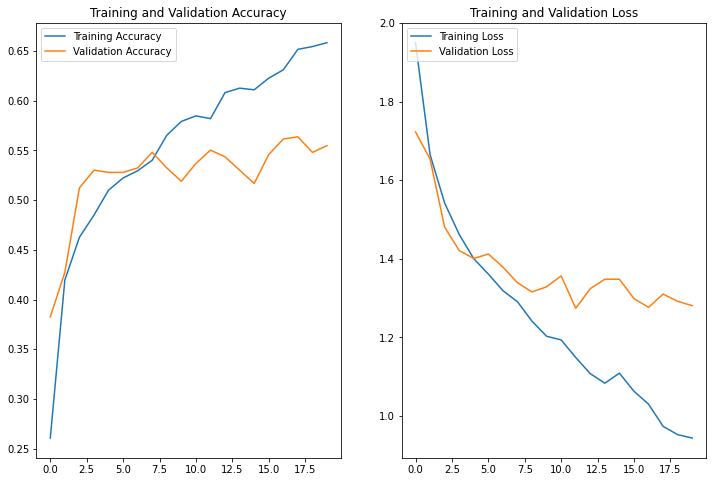

In [20]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig,ax = plt.subplots(1,2,figsize=(12, 8))

ax[0].plot(epochs_range, acc,     label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
ax[0].legend(loc='upper left')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs_range, loss, label='Training Loss')
ax[1].plot(epochs_range, val_loss, label='Validation Loss')
ax[1].legend(loc='upper left')
ax[1].set_title('Training and Validation Loss')

plt.show()

#### **Inference**

- The visualization shows overfitted model. For higher epoch values the training data is more accurate and for validation data the model is showing a low accuracy.
- The training accuracy keep increasing as we move for 0-20 epoch whereas the validation data shows equal trend for few initial epochs but the accuracy considerably reduces for the later epochs. Model accuracy is very high for training data and low for validation data. This is clear case of over-fitted model.
- Training loss keeps reduces for the epochs, model has overfitted and the loss is higher for validation set. For unseen data the accuracy is lower and the loss is higher, ie for validation set the model is making more wrong predictions and hence the loss is higher. This also indicates that the model is overfit.
- Model performs suboptimally for validation data (low validation accuracy and high validation loss) compared to training data. This is overfit.

**Models used**
- A different set and arrangements of convolutional layers were used in the model creation stage.
- Model is trained with lesser and additional Maxpooling layers as well.

- In some of the cases the accuracy is coming to be around **54%** for the validation dataset. 
- Multiple hyperparameters were tried and used for optimizers and loss functions, adam, adagrad, rmsprop, SGD, adadelta and the adamax and SparseCrossentropy is chosen as it showed better accuracy for the set of model created.

***Sample Model output charts***

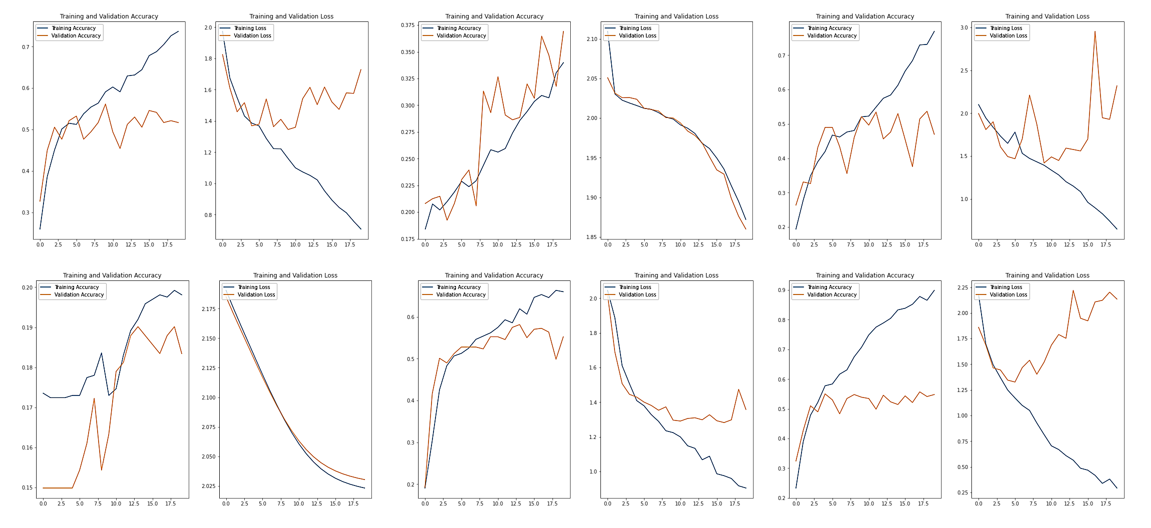

*Out of all these charts, the one with adamax optimizer and the SparseCategoricalCrossentropy loss is chosen as it gave best results for all different sets of models created*

## Augmentation

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=input_shape),
  layers.experimental.preprocessing.RandomRotation(0.15,'reflect'),
  layers.experimental.preprocessing.RandomZoom((0.1,0.2),(0.1,0.2),'reflect'),
])

#### Visualize the augmented data

**Subplot to visualize one instance of all the nine classes present in the dataset**

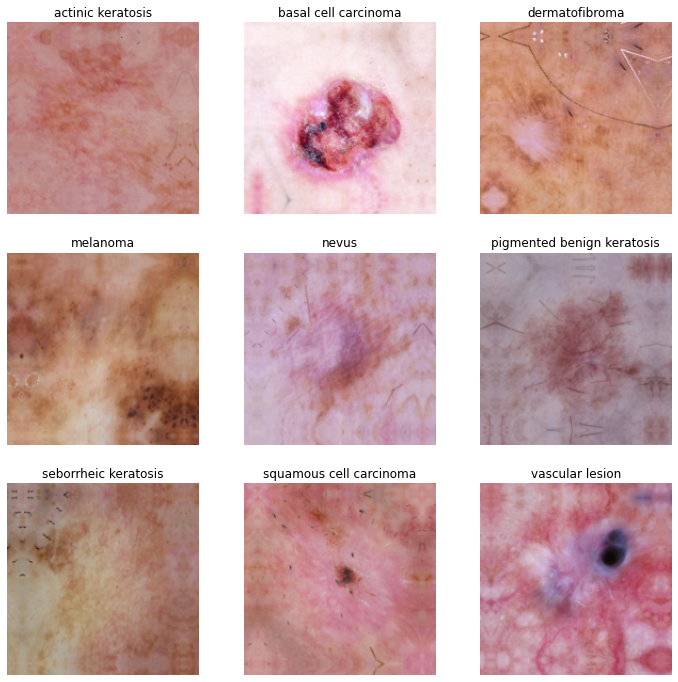

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(num_classes):
    while 1:
        images, labels = next(iter(train_ds.take(num_classes)))
        if i==labels[i]:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            break;

**Subplot to visualize first 9 images from the augmented dataset**

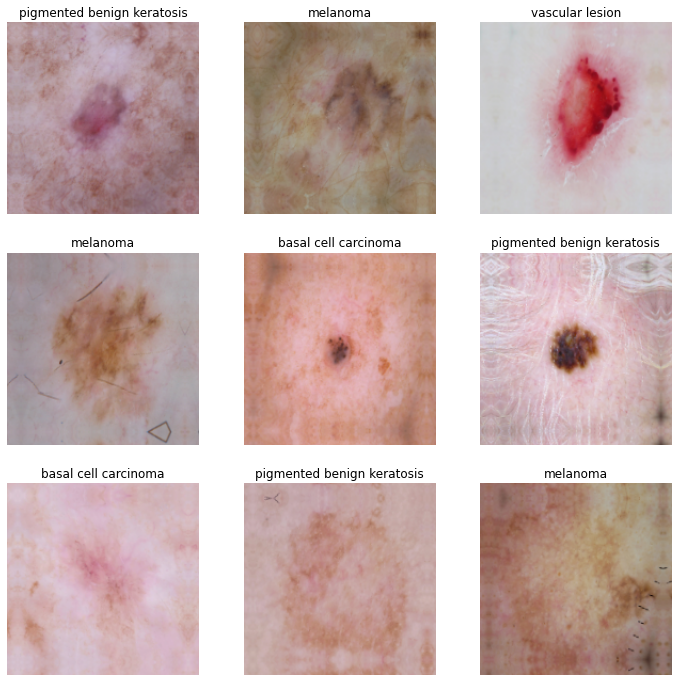

In [23]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model after Data Augmentation

### Create the model


*Drop out is used regularize the model.*

In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Model
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.50),
  layers.Dense(num_classes)
])

### Compiling the model

In [25]:
### Used adam optimizer and loss as SparceCategoricalCrossentropy
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Summary of all layers**

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 32)       

### Training the model

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 65ms/step - loss: 2.0964 - accuracy: 0.2037 - val_loss: 1.9963 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.9524 - accuracy: 0.2671 - val_loss: 1.7197 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7395 - accuracy: 0.3809 - val_loss: 1.6108 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6031 - accuracy: 0.4266 - val_loss: 1.6115 - val_accuracy: 0.4452
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5354 - accuracy: 0.4650 - val_loss: 1.5260 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5743 - accuracy: 0.4343 - val_loss: 1.5387 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 3s 59ms/step - loss: 1.5123 - accuracy: 0.4634 - val_loss: 1.4587 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

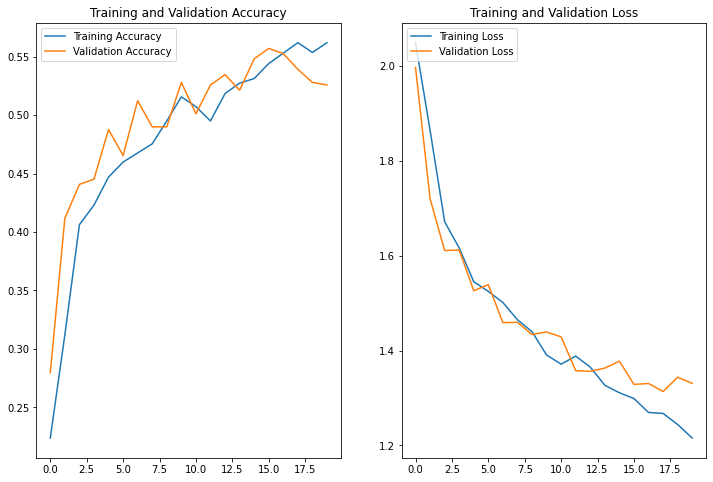

In [28]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig,ax = plt.subplots(1,2,figsize=(12, 8))

ax[0].plot(epochs_range, acc, label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
ax[0].legend(loc='upper left')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs_range, loss, label='Training Loss')
ax[1].plot(epochs_range, val_loss, label='Validation Loss')
ax[1].legend(loc='upper left')
ax[1].set_title('Training and Validation Loss')

plt.show()

#### **Inference**

- The visualization shows that the model is not overfitted. For higher epoch values the validation data is at par with the training data with respect to accuracy and the loss.
- The training and validation accuracy increases from 0-~0.55 for both training and validation data sets. However the maximum accuracy for both sets are within 0.55. In this model we dont have much overfitting however only 55% of data is correcly predicted for both training and validation data sets. This means the model is underfit i.e. not correcly predictiing 45% of training and validation data.
- The training and validation loss reduces from epoch 0-20 indicating that the model learns the data in training set and shows the same effect with validation set as well. 




**Models used**  
A different set of layers were used in the model creation stage and trained with lesser and additional Maxpooling layers as well. In most of the cases the accuracy is coming to be around 55% for the training and validation dataset. Also multiple hyperparameters are used for optimizers, adam and adagrad and the adam is chosen as it showed better accuracy for the set of model created.

Compared to the previous model, this model do not have over fitting for the validation data.

***Sample Model output charts***

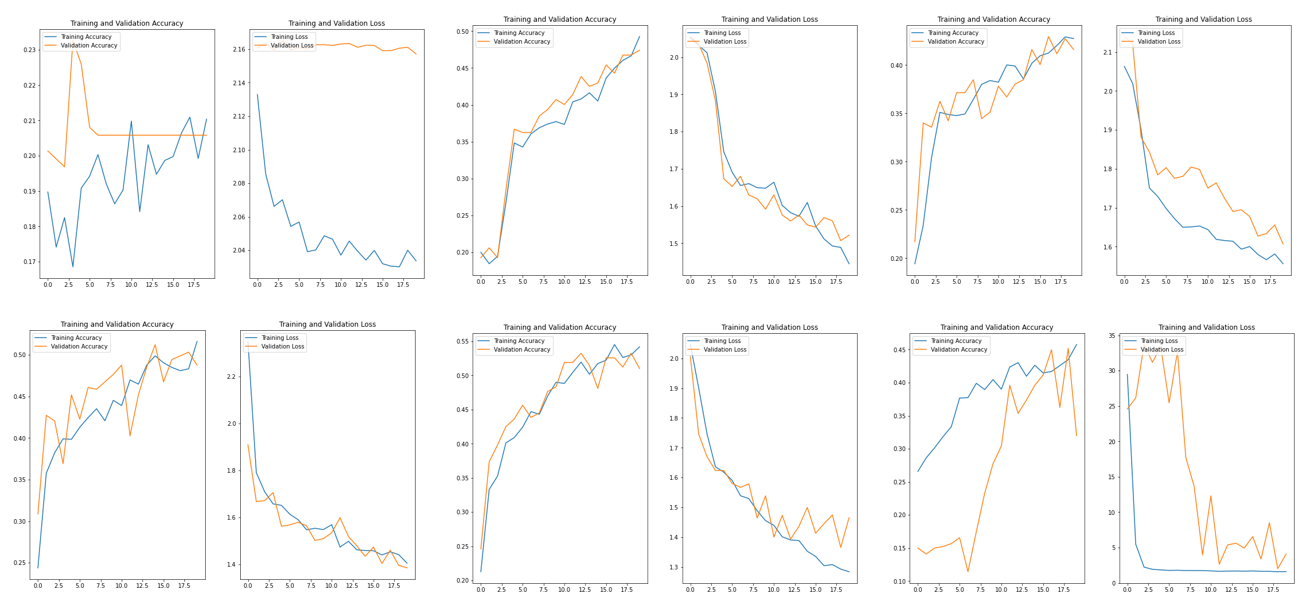

## Class Imbalance 

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **The distribution of classes in the training dataset.**


**Total Images in the Train folder**

In [29]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


**Images for each class**

In [30]:
count_images=[]
for single_path in data_dir_train.glob('*'):
    c_type = os.path.basename(single_path)
    c_count = len(list(single_path.glob('*.jpg')))
    c_percentage = round(100.*c_count/image_count_train,4)
    count_images.append([c_type,c_count,str(c_percentage)+'%'])

count_images.sort(key=lambda x:x[0])
df_images = pd.DataFrame(count_images,columns=['Cancer Type','Number of Images','Percentage'])
df_images

,Cancer Type,Number of Images,Percentage
0,actinic keratosis,114,5.0916%
1,basal cell carcinoma,376,16.7932%
2,dermatofibroma,95,4.243%
3,melanoma,438,19.5623%
4,nevus,357,15.9446%
5,pigmented benign keratosis,462,20.6342%
6,seborrheic keratosis,77,3.439%
7,squamous cell carcinoma,181,8.084%
8,vascular lesion,139,6.2081%


**Plotting the class distribution**

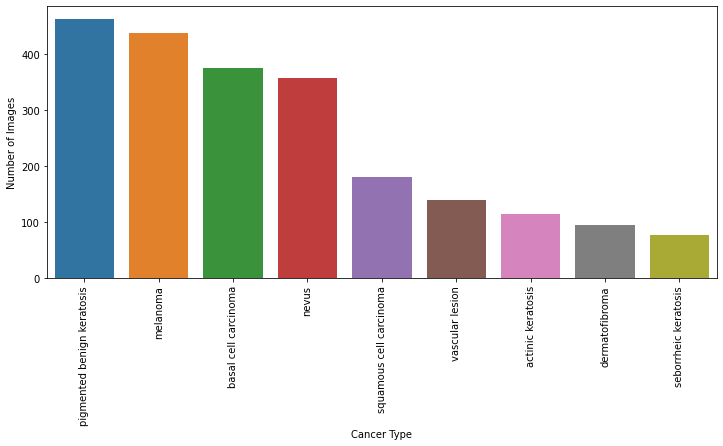

In [31]:
plt.figure(figsize=(12,5))
sns.barplot(x='Cancer Type',y='Number of Images',data = df_images.sort_values(by='Number of Images',ascending=False))
plt.xticks(rotation=90)
plt.show()

#### **Inference**

- There is a clear class imbalance with a percentage value ranging from 3.44% to 20.63%. 


---
##### **Which class has the least number of samples?**
- The least number of samples are in **```seborrheic keratosis```**. Number of samples in this class is **```77```**

##### **Which classes dominate the data in terms proportionate number of samples?**
- The most number of samples are in **```pigmented benign keratosis```**. Number of samples in this class is **```462```** which is ***```20.63%```*** of entire training datasets.  
___



## Rectification of Class Imbalance

**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
os.path.relpath(data_dir_train) + '/' 

'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

**Adding 500 samples per class to make sure that none of the classes are sparse.**

In [33]:
path_to_training_dataset=os.path.relpath(data_dir_train) + '/' 
print(path_to_training_dataset)

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA736562710>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7350FCFD0>:   0%|          | 1/500 [00:00<01:03,  7.84 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7E7455990>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA73669D350>:   0%|          | 2/500 [00:00<01:24,  5.90 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA736509150>: 100%|██████████| 500/500 [00:18<00:00, 26.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA736945350>: 100%|██████████| 500/500 [01:37<00:00,  5.10 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1028x753 at 0x7FA7369A1F10>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA73654B150>:   0%|          | 1/500 [00:00<01:08,  7.25 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA73654B150>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA7EB629E90>: 100%|██████████| 500/500 [00:45<00:00, 11.06 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA736663650>:   0%|          | 2/500 [00:00<01:04,  7.72 Samples/s]                  

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA73654FA50>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA736908450>:   0%|          | 1/500 [00:00<00:57,  8.65 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7F8ABAAD0>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. 

Lets take a look at total count of augmented images.

**Total Number of image samples in the training SubDirectories**

In [34]:
len(list(data_dir_train.glob('*/*.jpg')))

2239

**Total Number of image samples in the output folder inside training  SubDirectories**

In [35]:
len(list(data_dir_train.glob('*/output/*.jpg')))

4500

**Total Number of image samples in training**

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))+len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6739


### Class distribution of augmented data

after adding new images to the original training data.

In [37]:
count_images=[]
for single_path in data_dir_train.glob('*'):
    c_type = os.path.basename(single_path)
    c_count = len(list(single_path.glob('*.jpg')))+len(list(single_path.glob('output/*.jpg')))
    c_percentage = round(100.*c_count/image_count_train,4)
    count_images.append([c_type,c_count,str(c_percentage)+'%'])
    
count_images.sort(key=lambda x:x[0])
df_images = pd.DataFrame(count_images,columns=['Cancer Type','Number of Images','Percentage'])
df_images

,Cancer Type,Number of Images,Percentage
0,actinic keratosis,614,9.1111%
1,basal cell carcinoma,876,12.999%
2,dermatofibroma,595,8.8292%
3,melanoma,938,13.919%
4,nevus,857,12.717%
5,pigmented benign keratosis,962,14.2751%
6,seborrheic keratosis,577,8.5621%
7,squamous cell carcinoma,681,10.1054%
8,vascular lesion,639,9.4821%


**Plotting the class distribution after augmenting**

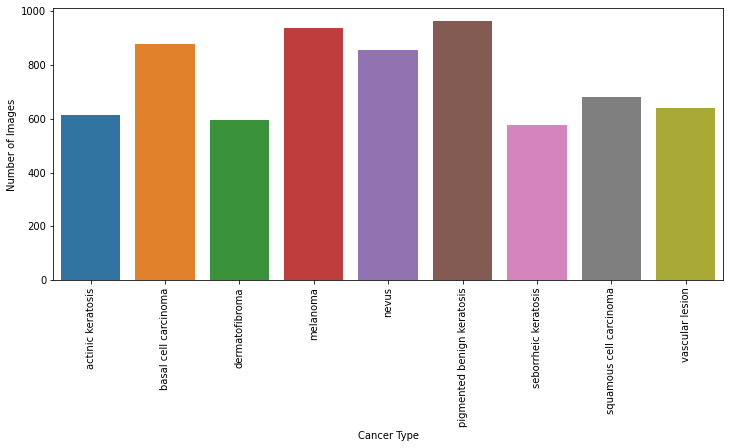

In [38]:
plt.figure(figsize=(12,5))
sns.barplot(x='Cancer Type',y='Number of Images',data = df_images)
plt.xticks(rotation=90)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Augmented Datasets

#### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
#data_dir_train=This is unchanged from top hence commented

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model after augmenting the data to rectify class imbalance

#### Create your model

**Model with data Augemnttion and class imbalance rectification**

*Drop out is used regularize the model.*

In [42]:
### input Shape
input_shape = (img_height,img_width,3)

# Model
model = Sequential([
  data_augmentation,                  
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.50),
  layers.Dense(num_classes)
])


#### Compile your model

In [43]:
## your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Summary of all layers**

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 43, 43, 32)       

#### Training model for 30 epochs

In [45]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 259ms/step - loss: 2.2152 - accuracy: 0.1278 - val_loss: 1.9718 - val_accuracy: 0.2168
Epoch 2/30
169/169 [==============================] - 44s 255ms/step - loss: 1.8459 - accuracy: 0.2708 - val_loss: 1.7357 - val_accuracy: 0.3311
Epoch 3/30
169/169 [==============================] - 44s 256ms/step - loss: 1.7047 - accuracy: 0.3276 - val_loss: 1.5762 - val_accuracy: 0.4113
Epoch 4/30
169/169 [==============================] - 44s 256ms/step - loss: 1.5465 - accuracy: 0.4182 - val_loss: 1.5435 - val_accuracy: 0.4150
Epoch 5/30
169/169 [==============================] - 44s 256ms/step - loss: 1.4796 - accuracy: 0.4288 - val_loss: 1.4342 - val_accuracy: 0.4588
Epoch 6/30
169/169 [==============================] - 44s 253ms/step - loss: 1.4444 - accuracy: 0.4503 - val_loss: 1.3935 - val_accuracy: 0.4633
Epoch 7/30
169/169 [==============================] - 44s 253ms/step - loss: 1.4142 - accuracy: 0.4501 - val_loss: 1.3541 - val_ac

#### Visualize the model results

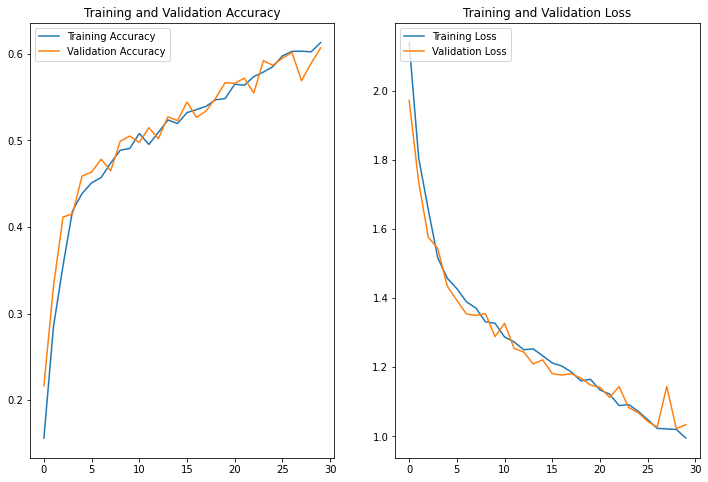

In [46]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig,ax = plt.subplots(1,2,figsize=(12, 8))

ax[0].plot(epochs_range, acc, label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
ax[0].legend(loc='upper left')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs_range, loss, label='Training Loss')
ax[1].plot(epochs_range, val_loss, label='Validation Loss')
ax[1].legend(loc='upper left')
ax[1].set_title('Training and Validation Loss')

plt.show()

#### **Inference**

- The visualization shows a perfect model for the augmented class balanced data. For higher epoch values the training and validation data follow the same trend. Accuracy is around 60% for training and validation data.
- The training and valdation accuracy keep increasing as we move for 0-30 epoch This shows that the model is making the predictions on the training and validation set in same manner.
- Training loss and validation loss shows similar trend. Loss keeps reduces for the epochs 0-30, model has learnt the pattern and predicts the results with a 60% confidence in both training and validation datasets for augmented data.

**Models used**
- A different set and arrangements of convolutional layers were used in the model creation stage.
- Model is trained with lesser and additional Maxpooling layers as well.

- In some of the cases the accuracy is coming to be around 60% for the validation dataset. 
- Multiple hyperparameters were tried and used for optimizers and loss functions, adam, adagrad, rmsprop, SGD, adadelta and the adamax and SparseCrossentropy is chosen as it showed better accuracy for the set of model created.

**Evaluating the model**

In [47]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

model.evaluate(test_ds)

Found 118 files belonging to 9 classes.
4/4 [==============================] - 5s 75ms/step - loss: 2.2954 - accuracy: 0.4322


[2.2953972816467285, 0.43220338225364685]

## Model the NN  data to rectify class imbalance

#### Create your model

**Model without data Augemnttion and with class imbalance rectification**

- ***Augmentation is removed as is is seen that the augmentation underfits the data in this particular case.***
- ***Batch Normalization is not carried out as it resulted in the lower accuracy for validation data***

*Drop out is used regularize the model.*

In [48]:
### input Shape
input_shape = (img_height,img_width,3)

# Model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.50),
  layers.Dense(num_classes)
])


#### Compile your model

In [49]:
## your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Summary of all layers**

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 41, 64)       

#### Training model for 30 epochs

In [51]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 51s 289ms/step - loss: 2.1961 - accuracy: 0.1449 - val_loss: 1.9194 - val_accuracy: 0.2880
Epoch 2/30
169/169 [==============================] - 49s 284ms/step - loss: 1.7894 - accuracy: 0.3036 - val_loss: 1.6657 - val_accuracy: 0.4150
Epoch 3/30
169/169 [==============================] - 48s 280ms/step - loss: 1.6322 - accuracy: 0.3702 - val_loss: 1.5280 - val_accuracy: 0.4491
Epoch 4/30
169/169 [==============================] - 48s 280ms/step - loss: 1.5679 - accuracy: 0.3933 - val_loss: 1.4078 - val_accuracy: 0.4878
Epoch 5/30
169/169 [==============================] - 48s 276ms/step - loss: 1.4789 - accuracy: 0.4337 - val_loss: 1.3639 - val_accuracy: 0.5026
Epoch 6/30
169/169 [==============================] - 48s 279ms/step - loss: 1.3921 - accuracy: 0.4725 - val_loss: 1.3112 - val_accuracy: 0.5278
Epoch 7/30
169/169 [==============================] - 51s 294ms/step - loss: 1.3369 - accuracy: 0.5036 - val_loss: 1.2714 - val_ac

#### Visualize the model results

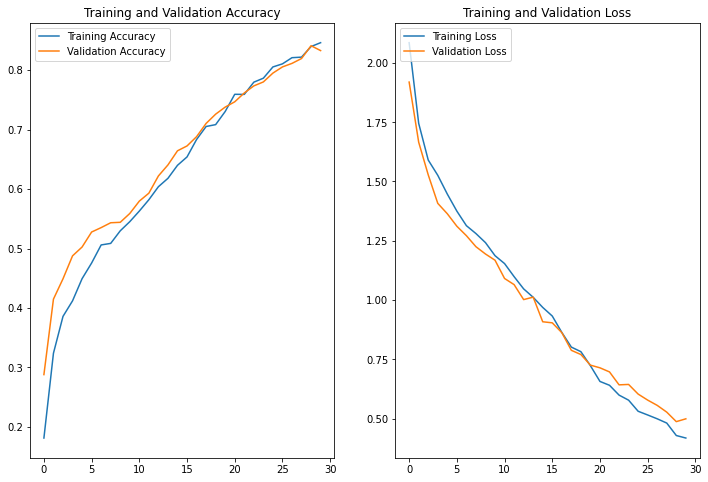

In [52]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig,ax = plt.subplots(1,2,figsize=(12, 8))

ax[0].plot(epochs_range, acc, label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
ax[0].legend(loc='upper left')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs_range, loss, label='Training Loss')
ax[1].plot(epochs_range, val_loss, label='Validation Loss')
ax[1].legend(loc='upper left')
ax[1].set_title('Training and Validation Loss')

plt.show()

#### **Inference**

- The visualization shows a perfect model for the class balanced data. For higher epoch values the training and validation data follow the same trend. Accuracy is around 81% for training and validation data.
- The training and valdation accuracy keep increasing as we move for 0-30 epoch This shows that the model is making the predictions on the training and validation set in same manner.
- Training loss and validation loss shows similar trend. Loss keeps reduces for the epochs 0-30, model has learnt the pattern and predicts the results with a 80% confidence in both training and validation datasets for augmented data.

**Models used**
- A different set and arrangements of convolutional layers were used in the model creation stage.
- Model is trained with lesser and additional Maxpooling layers as well.
- In some of the cases the accuracy is coming to be around 80% for the validation dataset. 
- Multiple hyperparameters were tried and used for optimizers and loss functions, adam, adagrad, rmsprop, SGD, adadelta and the adamax and SparseCrossentropy is chosen as it showed better accuracy for the set of model created.

**Sample Model output charts**

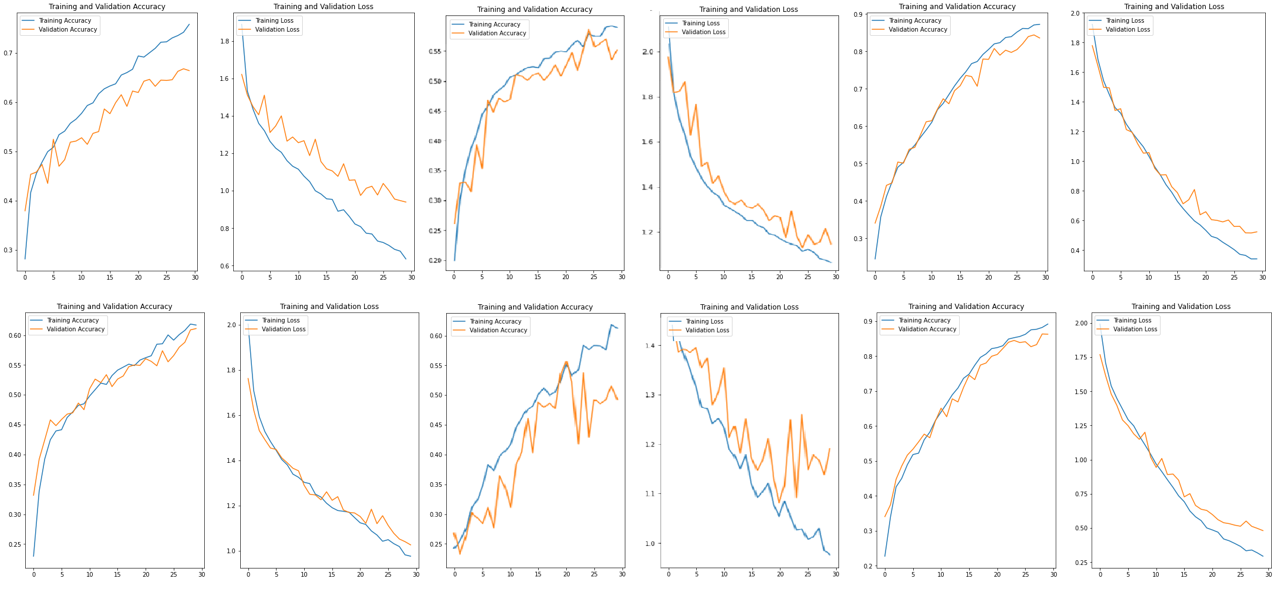